# 5) 글로벌 전술적 자산 배분 전략 GTAA3

In [1]:
!pip3 install finance-datareader==0.9.42
!pip3 install pandas-datareader==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 2.8 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [21]:
import FinanceDataReader as fdr
import pandas_datareader.data as web
from pandas_datareader import data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

In [22]:
def getCloseData(ticker, start, end=None):
    return fdr.DataReader(ticker, start, end)['Close']

def getCloseDataPandas(ticker, start, end):
    return data.get_data_yahoo(ticker, start, end)['Close']


def getDayReturn(closeDataSet):
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)


def getCumulativeReturn(closeDataSet):
    return closeDataSet / closeDataSet.iloc[0]


def getPortfolioResult(closeDataSet, weight=None):

    dayReturn = getDayReturn(closeDataSet)
    cumulativeReturn = getCumulativeReturn(closeDataSet)

    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)

    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn


def getEvaluation(cumulativeReturn):

    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()

    print(f"최종 수익률: {cumulativeReturn.iloc[-1]}\ncagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd


def getRebalancingDate(closeDataSet, period="month"):

    data = closeDataSet.copy()
    data = pd.DataFrame(data) # 시리즈형 데이터가 들어오더라도 리밸런싱 날짜를 계산하기
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    # 월말 리밸런싱
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "quarter":
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    if period == "year":
        # rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last")
        check = int(rebalancingDate.iloc[len(rebalancingDate)-1].to_list()[len(rebalancingDate.columns)-1])
        rebalancingDate= rebalancingDate[rebalancingDate['month']==check].index
    return rebalancingDate


def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):

    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)]
                                * len(rebalancingDate),index=rebalancingDate,columns=closeDataSet.columns)
        
    # 자산별 비중이 있는 경우
    else:
        closeDataSet = closeDataSet.loc[weightDf.index[0]:]
        rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜

    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성
    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[end] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영
        start = end # start 갱신
        if(netCumReturn.iloc[-1].sum() ==0):
            totalAsset =1
        else:
            totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가

    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)

    return portfolioDayReturn, portfolioCumulativeReturn

def getDay(str0):
    SY = int(str0[:4])
    SM = int(str0[5:7])
    SD = int(str0[8:10])
    return SY,SM,SD 

In [23]:
def avgMomentumScoretable(data, n=12, name="Close"):
  result = pd.DataFrame(data)

  if len(result.columns) ==1 :  
    result.columns = [name+"_m"]
    for i in range(len(data)-1,-1,-1):
      tmp =0
      if i>(n-1):
        for j in range(i-1,i-n-1, -1):
          if data[i]>data[j] : tmp = tmp+1
      result[name+"_m"][i] = tmp
  else : 
    name_list = result.columns
    for i in range(0, len(name_list)):
      result = pd.concat(   [result,avgMomentumScoretable(data[name_list[i]],n, name_list[i])/n] , axis=1 )
      result = result.drop([name_list[i]], axis=1)
    result.columns = name_list

  return  result[n:]

In [24]:
def weightScore(data):
  weight = data.divide(data.sum(axis=1), axis=0).fillna(0)
  # weight['cash'] = np.where(weight.sum(axis=1) == 0,1,0)
  return weight

In [25]:
start = "2010"
end = "2022-10-31"

In [26]:
SPY = getCloseDataPandas("SPY",start, end) #1
IWD = getCloseDataPandas("IWD",start, end)#2
IWM = getCloseDataPandas("IWM",start, end) #3
IWN = getCloseDataPandas("IWN",start, end) #4
MTUM = getCloseDataPandas("MTUM",start, end)#5
EFA = getCloseDataPandas("EFA",start, end) #6
TLT = getCloseDataPandas("TLT",start, end) #7
IEF = getCloseDataPandas("IEF",start, end) #8
LQD = getCloseDataPandas("LQD",start, end) #9
DBC = getCloseDataPandas("DBC",start, end) #10
VNQ = getCloseDataPandas("VNQ",start, end)#11
BWX = getCloseDataPandas("BWX",start, end) #12
GLD = getCloseDataPandas("GLD",start, end) #13


closeDataSet = pd.concat([SPY, IWD,IWM,IWN,MTUM,EFA,TLT,IEF,LQD,DBC,VNQ,BWX,GLD], axis=1)
closeDataSet.columns = ["SPY", "IWD","IWM","IWN","MTUM","EFA","TLT","IEF","LQD","DBC","VNQ","BWX","GLD"]
closeDataSet['cash'] =1
closeDataSet.dropna(inplace=True)
closeDataSet

,SPY,IWD,IWM,IWN,MTUM,EFA,TLT,IEF,LQD,DBC,VNQ,BWX,GLD,cash
Date,,,,,,,,,,,,,,
2013-04-18,154.139999,79.690002,89.580002,79.820000,50.919998,58.630001,123.089996,108.639999,121.529999,25.790001,72.680000,29.500000,134.300003,1
2013-04-19,155.479996,80.400002,90.610001,80.730003,50.919998,59.099998,122.830002,108.580002,121.709999,25.730000,73.800003,29.410000,135.470001,1
2013-04-22,156.169998,80.629997,90.870003,80.879997,50.919998,59.349998,122.919998,108.639999,121.750000,25.809999,73.699997,29.530001,137.899994,1
2013-04-23,157.779999,81.540001,92.309998,82.230003,52.220001,60.189999,122.489998,108.570000,121.910004,25.650000,74.110001,29.450001,136.880005,1
2013-04-24,157.880005,81.680000,92.790001,82.820000,51.560001,60.709999,122.800003,108.620003,121.959999,25.930000,74.269997,29.480000,138.369995,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-25,384.920013,147.020004,178.169998,140.619995,144.270004,59.279999,95.089996,94.180000,100.760002,25.090000,81.209999,20.889999,154.000000,1
2022-10-26,382.019989,147.490005,179.050003,141.250000,145.190002,59.840000,96.459999,94.660004,101.220001,25.559999,81.160004,21.129999,154.979996,1
2022-10-27,379.980011,147.309998,179.089996,141.899994,145.240005,59.279999,97.470001,95.330002,101.690002,25.600000,81.279999,21.160000,154.740005,1


In [27]:
rebalDate = getRebalancingDate(closeDataSet) #rebalancing_date
priceOnRebalDate = closeDataSet.loc[rebalDate] #rebal_close_data

In [28]:
weight = priceOnRebalDate.copy()

yi10 = ((weight/weight.shift(10))-1) * 100
yi1= ((weight/weight.shift(1))-1)*100
yi3= ((weight/weight.shift(3))-1)*100
yi6= ((weight/weight.shift(6))-1)*100
yi12= ((weight/weight.shift(12))-1)*100
avg = (yi1+yi3+yi6+yi12)/4
weight = np.where(avg<yi10, avg,np.NaN)
weight = pd.DataFrame(weight, index = priceOnRebalDate.index)
weight.columns = ["SPY", "IWD","IWM","IWN","MTUM","EFA","TLT","IEF","LQD","DBC","VNQ","BWX","GLD","cash"]


In [29]:
weight

,SPY,IWD,IWM,IWN,MTUM,EFA,TLT,IEF,LQD,DBC,VNQ,BWX,GLD,cash
Date,,,,,,,,,,,,,,
2013-04-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.328856,NaN,NaN,-2.016879,NaN
2022-07-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.802116,NaN,NaN,-3.892779,NaN
2022-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.415048,NaN,NaN,-6.683215,NaN


In [30]:
name_list =["SPY", "IWD","IWM","IWN","MTUM","EFA","TLT","IEF","LQD","DBC","VNQ","BWX","GLD"]

final_weight = pd.DataFrame( index = priceOnRebalDate.index, columns=closeDataSet.columns)

for i in range(0, len(final_weight)):
#  print("*"*40)
  tt =weight.iloc[i]
  t = tt.rank(method='max', na_option='bottom')
#  print(tt)
#  print("="*3)
#  print(t)
#  print("="*3)

  name = []
  for j in range(0,13):
    if t.iloc[j] <4 :
      name.append(name_list[j])

#  print(name)

  if(len(name) >0):
    for j in range(0, len(name)):
      final_weight[name[j]][i] = 1/3
  else:
    final_weight['cash'][i]=1
  
#  print(final_weight.iloc[i])



In [31]:
final_weight = final_weight.fillna(0)

In [32]:
final_weight['cash'] = 1-(final_weight['SPY']+final_weight['IWD']+final_weight['IWM']+final_weight['IWN']+final_weight['MTUM']+final_weight['EFA']+final_weight['TLT']+final_weight['IEF']+final_weight['LQD']+final_weight['DBC']+final_weight['VNQ']+final_weight['BWX']+final_weight['GLD'])

In [33]:
final_weight

,SPY,IWD,IWM,IWN,MTUM,EFA,TLT,IEF,LQD,DBC,VNQ,BWX,GLD,cash
Date,,,,,,,,,,,,,,
2013-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000
2013-05-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000
2013-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000
2013-07-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000
2013-08-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.333333
2022-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.333333
2022-08-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.333333,0.333333


In [34]:
_, CumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet,weightDf=final_weight)
cagr, dd, mdd = getEvaluation(CumReturn)

최종 수익률: 0.28621173657581
cagr: 0.8766638195461077
mdd: 72.7554081177799


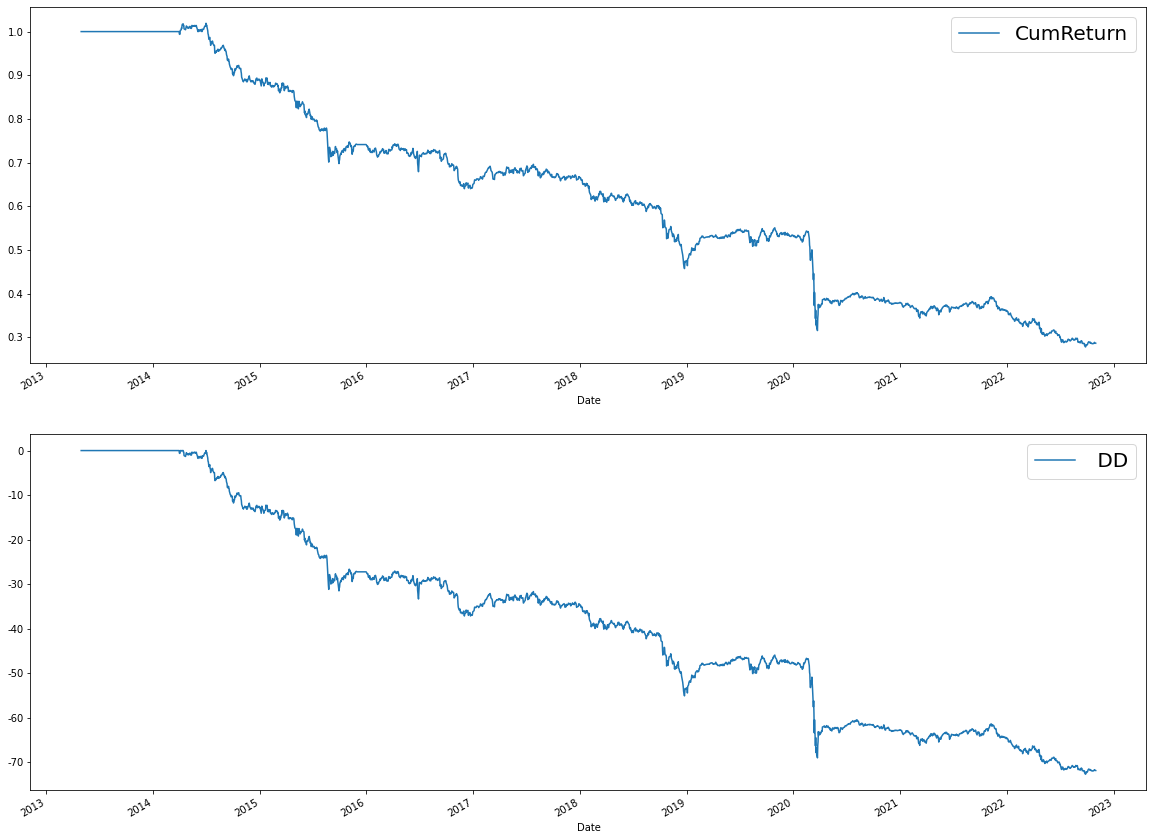

In [35]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,16))

# 수익곡선
plt.subplot(2,1,1)
CumReturn.plot(label="CumReturn")
plt.legend(fontsize=20)

# dd 곡선
plt.subplot(2,1,2)
(-dd).plot(label=" DD")
plt.legend(fontsize=20)

plt.show()